In [697]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import shap


import warnings
warnings.filterwarnings("ignore")

In [698]:
'Importing Data' 
DATA = pd.read_excel(r'C:/Users/Saad/Desktop/Explosibility-data-PBar.xlsx')
Data = pd.read_excel(r'C:/Users/Saad/Desktop/Explosibility-data-PBar.xlsx')

In [699]:
DATA.head()

,Type,Conc(mg/L),Size(µm),TM,Ash,VM,FC,GCV(Kcal/Kg),Pmax(bar),Kst(bar.m/s)
0,1,500,-125,6.0,26.0,15.45,49.7,4901.0,2.26,0.400397
1,2,100,-43,6.4,17.5,12.30,60.5,6318.2,0.17,0.031157
2,2,200,-43,6.4,17.5,12.30,60.5,6318.2,0.18,0.030371
3,2,300,-43,6.4,17.5,12.30,60.5,6318.2,0.16,0.030924
4,2,400,-43,6.4,17.5,12.30,60.5,6318.2,0.18,0.030371


In [700]:
DATA.describe()

,Type,Conc(mg/L),Size(µm),TM,Ash,VM,FC,GCV(Kcal/Kg),Pmax(bar),Kst(bar.m/s)
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,2.333333,405.555556,-78.666667,6.622222,18.933333,11.761111,59.566667,6072.733333,2.058031,0.422234
std,0.670820,251.495527,33.420054,0.360555,2.567586,1.619336,3.521647,427.300859,0.877837,0.165627
min,1.000000,50.000000,-125.000000,6.000000,17.500000,10.300000,49.700000,4901.000000,0.150000,0.023622
25%,2.000000,200.000000,-120.000000,6.400000,17.500000,10.300000,60.500000,6120.200000,1.945607,0.443143
50%,2.000000,400.000000,-73.000000,6.400000,18.600000,12.300000,60.500000,6120.200000,2.351014,0.471939
75%,3.000000,600.000000,-53.000000,7.000000,18.600000,12.300000,61.100000,6318.200000,2.640029,0.505167
max,3.000000,800.000000,-43.000000,7.000000,26.000000,15.450000,61.100000,6318.200000,3.410037,0.661488


In [701]:
Data = Data[(Data['Type'] == 1)|(Data['Type'] == 2) | (Data['Type'] == 3)]

In [702]:
#T2_T1 = Data['(T2-T1)ms']
#T2_max = Data['(Tmax-T2)ms']
Data = Data.drop(['Type'],axis=1)
#Data = Data.drop(['Type','TM','VM','Ash','FC'],axis=1)
#Data = Data.drop(['coaltype'],axis=1)

In [703]:
Data['Size(µm)'][Data['Size(µm)'] == -43] = 30
Data['Size(µm)'][Data['Size(µm)'] == -53] = 40
Data['Size(µm)'][Data['Size(µm)'] == -73] = 55
Data['Size(µm)'][Data['Size(µm)'] == -120] = 90
Data['Size(µm)'][Data['Size(µm)'] == -125] = 95
Data['Size(µm)'][Data['Size(µm)'] == 125] = 150

In [704]:
Data.describe()

,Conc(mg/L),Size(µm),TM,Ash,VM,FC,GCV(Kcal/Kg),Pmax(bar),Kst(bar.m/s)
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,405.555556,58.888889,6.622222,18.933333,11.761111,59.566667,6072.733333,2.058031,0.422234
std,251.495527,25.956695,0.360555,2.567586,1.619336,3.521647,427.300859,0.877837,0.165627
min,50.000000,30.000000,6.000000,17.500000,10.300000,49.700000,4901.000000,0.150000,0.023622
25%,200.000000,40.000000,6.400000,17.500000,10.300000,60.500000,6120.200000,1.945607,0.443143
50%,400.000000,55.000000,6.400000,18.600000,12.300000,60.500000,6120.200000,2.351014,0.471939
75%,600.000000,90.000000,7.000000,18.600000,12.300000,61.100000,6318.200000,2.640029,0.505167
max,800.000000,95.000000,7.000000,26.000000,15.450000,61.100000,6318.200000,3.410037,0.661488


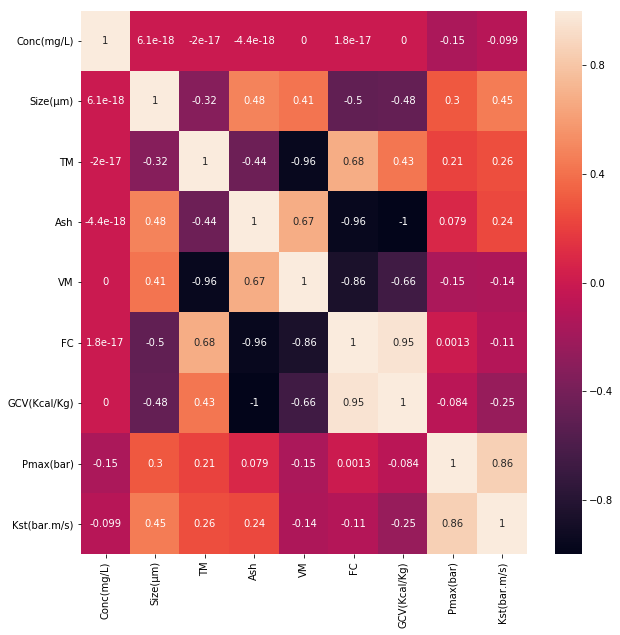

In [705]:
plt.figure(figsize=(10,10))
sns.heatmap(Data.corr(),annot=True)

In [706]:
Data['Size(µm)'].unique()

array([95, 30, 40, 55, 90], dtype=int64)

#### m = Folder Name in which we want to save the figures

In [707]:
m = 'Model New Data'

In [708]:
Data.columns

Index(['Conc(mg/L)', 'Size(µm)', 'TM', 'Ash', 'VM', 'FC', 'GCV(Kcal/Kg)',
       'Pmax(bar)', 'Kst(bar.m/s)'],
      dtype='object')

In [710]:
q1 = Data.quantile(0.25)
q3 = Data.quantile(0.75)
lower = q1 - 1.5*(q3 - q1)
upper = q3 + 1.5*(q3 - q1)
pd.concat([lower, upper], axis=1).transpose().rename(index={0: "Lower", 1: "Upper"})

,Conc(mg/L),Size(µm),TM,Ash,VM,FC,GCV(Kcal/Kg),Pmax(bar),Kst(bar.m/s)
Lower,-400.0,-35.0,5.5,15.85,7.3,59.6,5823.2,0.903976,0.350107
Upper,1200.0,165.0,7.9,20.25,15.3,62.0,6615.2,3.681660,0.598203


In [711]:
'Checking for Null Values'
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 0 to 80
Data columns (total 9 columns):
Conc(mg/L)      81 non-null int64
Size(µm)        81 non-null int64
TM              81 non-null float64
Ash             81 non-null float64
VM              81 non-null float64
FC              81 non-null float64
GCV(Kcal/Kg)    81 non-null float64
Pmax(bar)       81 non-null float64
Kst(bar.m/s)    81 non-null float64
dtypes: float64(7), int64(2)
memory usage: 6.3 KB


In [712]:
Data.columns

Index(['Conc(mg/L)', 'Size(µm)', 'TM', 'Ash', 'VM', 'FC', 'GCV(Kcal/Kg)',
       'Pmax(bar)', 'Kst(bar.m/s)'],
      dtype='object')

In [713]:
Data.shape

(81, 9)

In [714]:
Data.describe()

,Conc(mg/L),Size(µm),TM,Ash,VM,FC,GCV(Kcal/Kg),Pmax(bar),Kst(bar.m/s)
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,405.555556,58.888889,6.622222,18.933333,11.761111,59.566667,6072.733333,2.058031,0.422234
std,251.495527,25.956695,0.360555,2.567586,1.619336,3.521647,427.300859,0.877837,0.165627
min,50.000000,30.000000,6.000000,17.500000,10.300000,49.700000,4901.000000,0.150000,0.023622
25%,200.000000,40.000000,6.400000,17.500000,10.300000,60.500000,6120.200000,1.945607,0.443143
50%,400.000000,55.000000,6.400000,18.600000,12.300000,60.500000,6120.200000,2.351014,0.471939
75%,600.000000,90.000000,7.000000,18.600000,12.300000,61.100000,6318.200000,2.640029,0.505167
max,800.000000,95.000000,7.000000,26.000000,15.450000,61.100000,6318.200000,3.410037,0.661488


In [715]:
Data['Size(µm)'].unique()

array([95, 30, 40, 55, 90], dtype=int64)

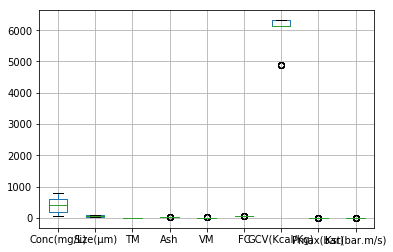

In [716]:
Data.boxplot()

In [717]:
Data.head()

,Conc(mg/L),Size(µm),TM,Ash,VM,FC,GCV(Kcal/Kg),Pmax(bar),Kst(bar.m/s)
0,500,95,6.0,26.0,15.45,49.7,4901.0,2.26,0.400397
1,100,30,6.4,17.5,12.30,60.5,6318.2,0.17,0.031157
2,200,30,6.4,17.5,12.30,60.5,6318.2,0.18,0.030371
3,300,30,6.4,17.5,12.30,60.5,6318.2,0.16,0.030924
4,400,30,6.4,17.5,12.30,60.5,6318.2,0.18,0.030371


In [718]:
'Importing Model'
from sklearn.ensemble import RandomForestRegressor

In [719]:
Data.head()

,Conc(mg/L),Size(µm),TM,Ash,VM,FC,GCV(Kcal/Kg),Pmax(bar),Kst(bar.m/s)
0,500,95,6.0,26.0,15.45,49.7,4901.0,2.26,0.400397
1,100,30,6.4,17.5,12.30,60.5,6318.2,0.17,0.031157
2,200,30,6.4,17.5,12.30,60.5,6318.2,0.18,0.030371
3,300,30,6.4,17.5,12.30,60.5,6318.2,0.16,0.030924
4,400,30,6.4,17.5,12.30,60.5,6318.2,0.18,0.030371


In [720]:
X = Data.iloc[:,:-2]
Y = Data.iloc[:,-2:]

In [721]:
print(X.head())
Y.head()

   Conc(mg/L)  Size(µm)   TM   Ash     VM    FC  GCV(Kcal/Kg)
0         500        95  6.0  26.0  15.45  49.7        4901.0
1         100        30  6.4  17.5  12.30  60.5        6318.2
2         200        30  6.4  17.5  12.30  60.5        6318.2
3         300        30  6.4  17.5  12.30  60.5        6318.2
4         400        30  6.4  17.5  12.30  60.5        6318.2


,Pmax(bar),Kst(bar.m/s)
0,2.26,0.400397
1,0.17,0.031157
2,0.18,0.030371
3,0.16,0.030924
4,0.18,0.030371


In [722]:
Scaler_X = MinMaxScaler()
Scaler_Y = MinMaxScaler()

X = Scaler_X.fit_transform(X)
Y = Scaler_Y.fit_transform(Y)

# PCA

In [732]:
import numpy as np
from sklearn.decomposition import PCA

In [733]:
PC_data = Data 
pca = PCA(n_components=len(Data.columns))
pca.fit(Data)

PCA(n_components=9)

In [734]:
print(pca.explained_variance_ratio_)

[7.41320057e-01 2.56558725e-01 2.10773730e-03 1.10822797e-05
 2.38018780e-06 1.79695520e-08 1.69567654e-33 1.38642412e-35
 1.63174219e-37]


In [843]:
writer = pd.ExcelWriter('Components.xlsx',engine='xlsxwriter')
workbook=writer.book
worksheet=workbook.add_worksheet('Result')
writer.sheets['Result'] = worksheet
#worksheet.write_string(0, 0, df1.name)

In [844]:
pd.DataFrame(pca.explained_variance_).to_excel(writer,float_format="%.8f",sheet_name='Result',startrow=0 , startcol=0)
pd.DataFrame(pca.components_[0]).to_excel(writer,float_format="%.8f",sheet_name='Result',startrow=0 , startcol=4)
pd.DataFrame(pca.components_[1]).to_excel(writer,float_format="%.8f",sheet_name='Result',startrow=0 , startcol=6)
pd.DataFrame(pca.components_[2]).to_excel(writer,float_format="%.8f",sheet_name='Result',startrow=0 , startcol=8)
pd.DataFrame(pca.components_[3]).to_excel(writer,float_format="%.8f",sheet_name='Result',startrow=0 , startcol=10)
pd.DataFrame(pca.components_[4]).to_excel(writer,float_format="%.8f",sheet_name='Result',startrow=0 , startcol=12)
pd.DataFrame(pca.components_[5]).to_excel(writer,float_format="%.8f",sheet_name='Result',startrow=0 , startcol=14)
pd.DataFrame(pca.components_[6]).to_excel(writer,float_format="%.8f",sheet_name='Result',startrow=0 , startcol=16)
pd.DataFrame(pca.components_[7]).to_excel(writer,float_format="%.8f",sheet_name='Result',startrow=0 , startcol=18)
pd.DataFrame(pca.components_[8]).to_excel(writer,float_format="%.8f",sheet_name='Result',startrow=0 , startcol=20)
writer.save()

In [826]:
pd.DataFrame(pca.explained_variance_).to_excel('New.xlsx')

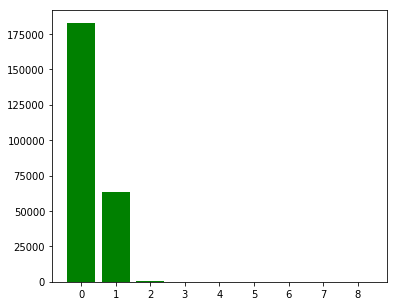

In [736]:
plt.figure(figsize=(6,5))
plt.bar(range(len(pca.explained_variance_)),pca.explained_variance_,color='green')
plt.xticks(list(range(len(pca.explained_variance_))))
plt.show()

[-5.08328858e-08  2.90938662e-02 -3.59002773e-04  6.00515392e-03
  2.50769125e-03 -7.86426490e-03 -9.99524478e-01  1.72681955e-04
  9.60330109e-05]


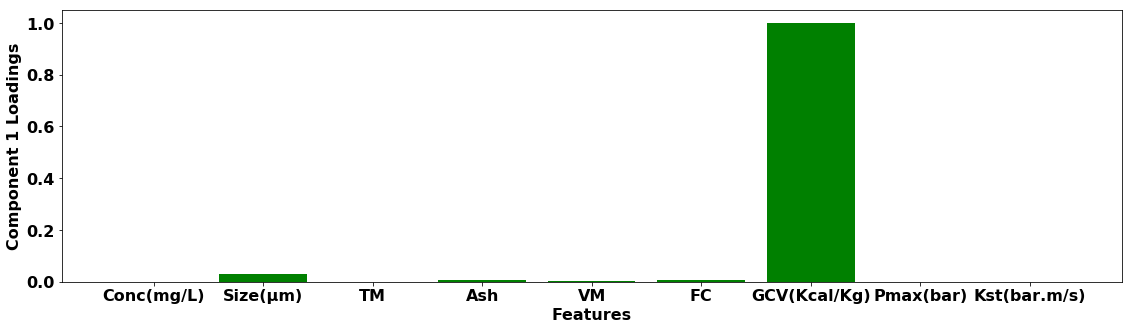

In [737]:
print(pca.components_[0])
plt.figure(figsize=(19,5))
plt.bar(range(len(pca.explained_variance_)),abs(pca.components_[0]),color='green')
plt.xticks(list(range(len(pca.explained_variance_))),list(Data.columns),size=16,weight='bold')
plt.yticks(size=16,weight='bold')
plt.ylabel('Component 1 Loadings',size=16,weight='bold')
plt.xlabel('Features',size=16,weight='bold')
plt.show()

[ 9.99999863e-01 -4.67679259e-08 -7.16608258e-10  9.79378624e-10
  2.83987558e-09 -3.29951820e-09 -1.48273514e-07 -5.19777028e-04
 -6.55249991e-05]


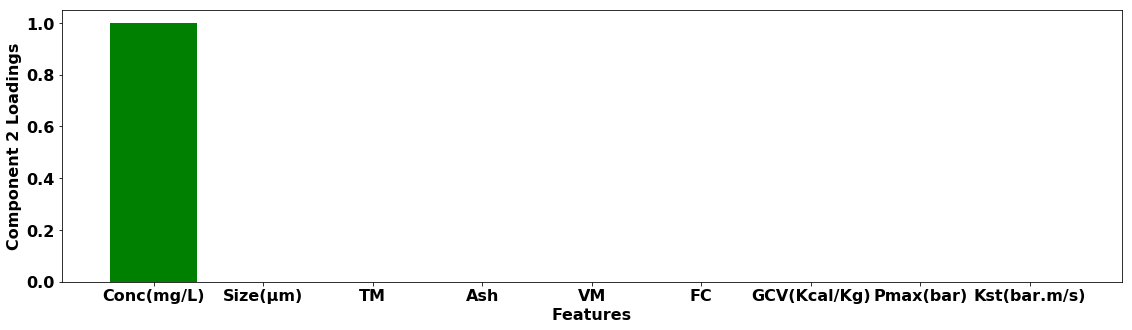

In [738]:
print(pca.components_[1])
plt.figure(figsize=(19,5))
plt.bar(range(len(pca.explained_variance_)),abs(pca.components_[1]),color='green')
plt.xticks(list(range(len(pca.explained_variance_))),list(Data.columns),size=16,weight='bold')
plt.yticks(size=16,weight='bold')
plt.ylabel('Component 2 Loadings',size=16,weight='bold')
plt.xlabel('Features',size=16,weight='bold')
plt.show()

[ 6.21947565e-06  9.99448628e-01 -2.13372134e-03  1.10985849e-04
  7.90389564e-03 -6.66482673e-03  2.91676133e-02  1.15236880e-02
  2.72728994e-03]


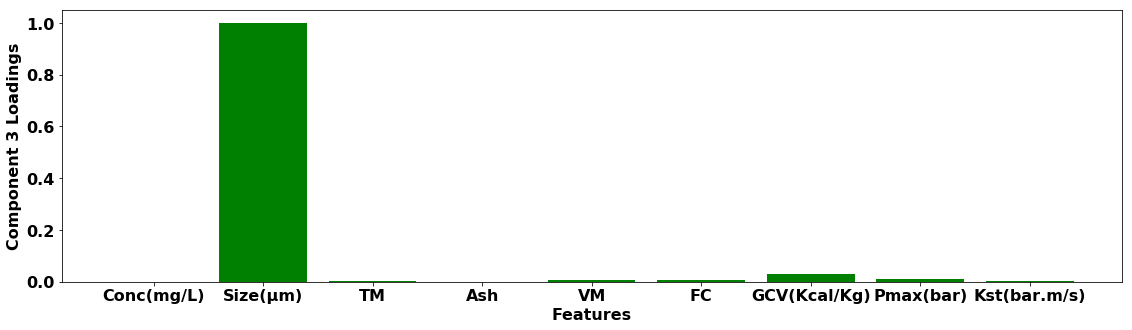

In [739]:
print(pca.components_[2])
plt.figure(figsize=(19,5))
plt.bar(range(len(pca.explained_variance_)),abs(pca.components_[2]),color='green')
plt.xticks(list(range(len(pca.explained_variance_))),list(Data.columns),size=16,weight='bold')
plt.yticks(size=16,weight='bold')
plt.ylabel('Component 3 Loadings',size=16,weight='bold')
plt.xlabel('Features',size=16,weight='bold')
plt.show()

[ 1.17429578e-04  7.80991971e-03  1.94077280e-01 -2.58672491e-02
 -7.22019283e-01  6.23979033e-01 -6.67571900e-03  2.19173392e-01
  5.34852055e-02]


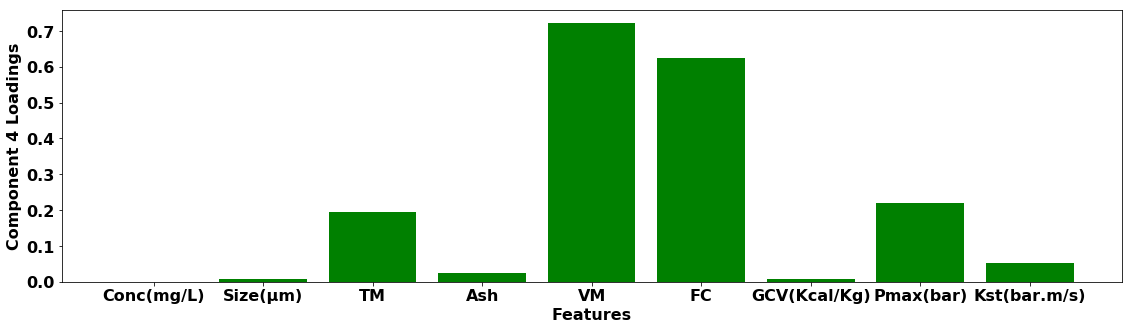

In [740]:
print(pca.components_[3])
plt.figure(figsize=(19,5))
plt.bar(range(len(pca.explained_variance_)),abs(pca.components_[3]),color='green')
plt.xticks(list(range(len(pca.explained_variance_))),list(Data.columns),size=16,weight='bold')
plt.yticks(size=16,weight='bold')
plt.ylabel('Component 4 Loadings',size=16,weight='bold')
plt.xlabel('Features',size=16,weight='bold')
plt.show()

In [629]:
# lst1 = []
# lst2 = []
# lst3 = []

# for u in range(1,101):
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30,random_state=u)

#     # Create the parameter grid based on the results of random search 
#     param_grid = {
#         'max_depth': [2,5,6,10],'n_estimators': [10,20,30,50,100],
#         'min_samples_split':[2,3,4],'min_samples_leaf':[1,2,3,4]}

#     rf = RandomForestRegressor(random_state=42)

#     # Instantiate the grid search model
#     grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                               cv = 5, n_jobs = -1, verbose = 2,scoring='r2')


#     # Fit the grid search to the data
#     grid_search.fit(X_train, Y_train)
#     grid_search.best_params_

#     best_grid = grid_search.best_estimator_
#     #print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

#     if best_grid.score(X_test,Y_test) > 0.76:
#         print(u)
#         print(best_grid)
#         print(best_grid.score(X_test,Y_test))
#         lst1.append(u)
#         lst2.append(best_grid)
#         lst3.append(best_grid.score(X_test,Y_test))

In [630]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30,random_state=37)

# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'max_depth': [2,5,6,10],'n_estimators': [10,20,30,50,100],
#     'min_samples_split':[2,3,4],'min_samples_leaf':[1,2,3,4]}

# rf = RandomForestRegressor(random_state=42)

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 5, n_jobs = -1, verbose = 2,scoring='r2')


# # Fit the grid search to the data
# grid_search.fit(X_train, Y_train)
# grid_search.best_params_

# best_grid = grid_search.best_estimator_
# #print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

# best_grid

In [631]:
lst1 = [8, 15, 33, 34, 43, 44, 55, 60, 62, 66, 74, 87, 88, 98]
lst2 = [RandomForestRegressor(max_depth=2, min_samples_split=3, n_estimators=50,
                        random_state=42),
  RandomForestRegressor(max_depth=5, min_samples_leaf=2, random_state=42),
  RandomForestRegressor(max_depth=2, n_estimators=10, random_state=42),
  RandomForestRegressor(max_depth=2, n_estimators=10, random_state=42),
  RandomForestRegressor(max_depth=2, min_samples_split=4, random_state=42),
  RandomForestRegressor(max_depth=2, random_state=42),
  RandomForestRegressor(max_depth=2, min_samples_split=4, n_estimators=20,
                        random_state=42),
  RandomForestRegressor(max_depth=5, min_samples_split=4, n_estimators=10,
                        random_state=42),
  RandomForestRegressor(max_depth=2, min_samples_leaf=2, n_estimators=20,
                        random_state=42),
  RandomForestRegressor(max_depth=2, min_samples_leaf=2, random_state=42),
  RandomForestRegressor(max_depth=2, n_estimators=30, random_state=42),
  RandomForestRegressor(max_depth=2, n_estimators=30, random_state=42),
  RandomForestRegressor(max_depth=2, min_samples_split=3, random_state=42),
  RandomForestRegressor(max_depth=2, n_estimators=10, random_state=42)]
lst3 =  [0.7889188884191323,
  0.8123896294828286,
  0.827532454107886,
  0.8311479798624763,
  0.8373088888617859,
  0.8254318101997735,
  0.7781518132936411,
  0.8200084651452864,
  0.805481283515624,
  0.83159016683641,
  0.810594600305511,
  0.770600474860098,
  0.851502248798881,
  0.7661919461397859]

In [632]:
lst1,lst2,lst3

([8, 15, 33, 34, 43, 44, 55, 60, 62, 66, 74, 87, 88, 98],
 [RandomForestRegressor(max_depth=2, min_samples_split=3, n_estimators=50,
                        random_state=42),
  RandomForestRegressor(max_depth=5, min_samples_leaf=2, random_state=42),
  RandomForestRegressor(max_depth=2, n_estimators=10, random_state=42),
  RandomForestRegressor(max_depth=2, n_estimators=10, random_state=42),
  RandomForestRegressor(max_depth=2, min_samples_split=4, random_state=42),
  RandomForestRegressor(max_depth=2, random_state=42),
  RandomForestRegressor(max_depth=2, min_samples_split=4, n_estimators=20,
                        random_state=42),
  RandomForestRegressor(max_depth=5, min_samples_split=4, n_estimators=10,
                        random_state=42),
  RandomForestRegressor(max_depth=2, min_samples_leaf=2, n_estimators=20,
                        random_state=42),
  RandomForestRegressor(max_depth=2, min_samples_leaf=2, random_state=42),
  RandomForestRegressor(max_depth=2, n_estimators=

# Scaled Training - Testing

In [633]:
a = 1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30,random_state=lst1[a])
#rf = RandomForestRegressor(n_estimators=65,max_depth=10,random_state=42,oob_score=True)
rf = lst2[a]
#Best 2 var GCV = max_depth:5, n_estimators:200, random_state:42 - test_size:0.25, random_state:16
#Best 2 var GCV = max_depth:5, n_estimators:500, random_state:42 - test_size:0.25, random_state:18

mod = rf.fit(X_train,Y_train)
preds = mod.predict(X_test)

print('Testing Accuracy')
One = pearsonr(Y_test[:,0],preds[:,0])
Two = pearsonr(Y_test[:,1],preds[:,1])
print(One[0],Two[0])

print('Training Accuracy')
preds_train = mod.predict(X_train)

One = pearsonr(Y_train[:,0],preds_train[:,0])
Two = pearsonr(Y_train[:,1],preds_train[:,1])
print(One[0],Two[0])

print('R2 Score')
One = r2_score(Y_test[:,0],preds[:,0])
Two = r2_score(Y_test[:,1],preds[:,1])
print(One,Two)

print('\n')
print('Mean Absolute Error1:', metrics.mean_absolute_error(Y_test[:,0], preds[:,0]))  
print('Mean Squared Error1:', metrics.mean_squared_error(Y_test[:,0], preds[:,0]))  
print('Root Mean Squared Error1:', np.sqrt(metrics.mean_squared_error(Y_test[:,0], preds[:,0])))

print('Mean Absolute Error2:', metrics.mean_absolute_error(Y_test[:,1], preds[:,1]))  
print('Mean Squared Error2:', metrics.mean_squared_error(Y_test[:,1], preds[:,1]))  
print('Root Mean Squared Error2:', np.sqrt(metrics.mean_squared_error(Y_test[:,1], preds[:,1])))

Testing Accuracy
0.8926363297771557 0.960303427732768
Training Accuracy
0.8606467925438664 0.9114634957340865
R2 Score
0.7164469066575179 0.9083323523081391


Mean Absolute Error1: 0.11079254870868166
Mean Squared Error1: 0.018660259481842544
Root Mean Squared Error1: 0.13660256030485865
Mean Absolute Error2: 0.0540632697474895
Mean Squared Error2: 0.0052438591573045
Root Mean Squared Error2: 0.07241449549161065


In [634]:
mod.random_state

42

In [635]:
mod.min_samples_split,rf.max_depth,rf.min_samples_leaf,rf.n_estimators

(2, 5, 2, 100)

In [636]:
mod.min_samples_split,best_grid.max_depth,best_grid.min_samples_leaf,best_grid.n_estimators

(2, 2, 1, 50)

In [637]:
mod.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [638]:
mod.score(X,Y)

0.7855273570376093

In [639]:
DATA.columns

Index(['Type', 'Conc(mg/L)', 'Size(µm)', 'TM', 'Ash', 'VM', 'FC',
       'GCV(Kcal/Kg)', 'Pmax(bar)', 'Kst(bar.m/s)'],
      dtype='object')

In [640]:
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

X.columns = ['Conc (mg/L)','Size (µm)','GCV (Kcal/Kg)']
X.head(3)

,Conc (mg/L),Size (µm),GCV (Kcal/Kg)
0,0.600000,1.0,0.0
1,0.066667,0.0,1.0
2,0.200000,0.0,1.0


In [641]:
Y_1st_act = list(Y_train[:,0]) + list(Y_test[:,0])
Y_2nd_act = list(Y_train[:,1]) + list(Y_test[:,1])

Y_1st_pred = list(preds_train[:,0]) + list(preds[:,0])
Y_2nd_pred = list(preds_train[:,1]) + list(preds[:,1])

D = {'Pmax':Y_1st_act,'Kst':Y_2nd_act}
D2 = {'Pmax':Y_1st_pred,'Kst':Y_2nd_pred}

Y_transformed_act = pd.DataFrame(D)
Y_transformed_pred = pd.DataFrame(D2)

In [642]:
Y_act = Scaler_Y.inverse_transform(Y_transformed_act)
Y_pred = Scaler_Y.inverse_transform(Y_transformed_pred)

In [643]:
Yx = Y_act[:,0]
Px = Y_pred[:,0]

In [644]:
One = pearsonr(Yx,Px)
print(One[0])

0.8638836243342707


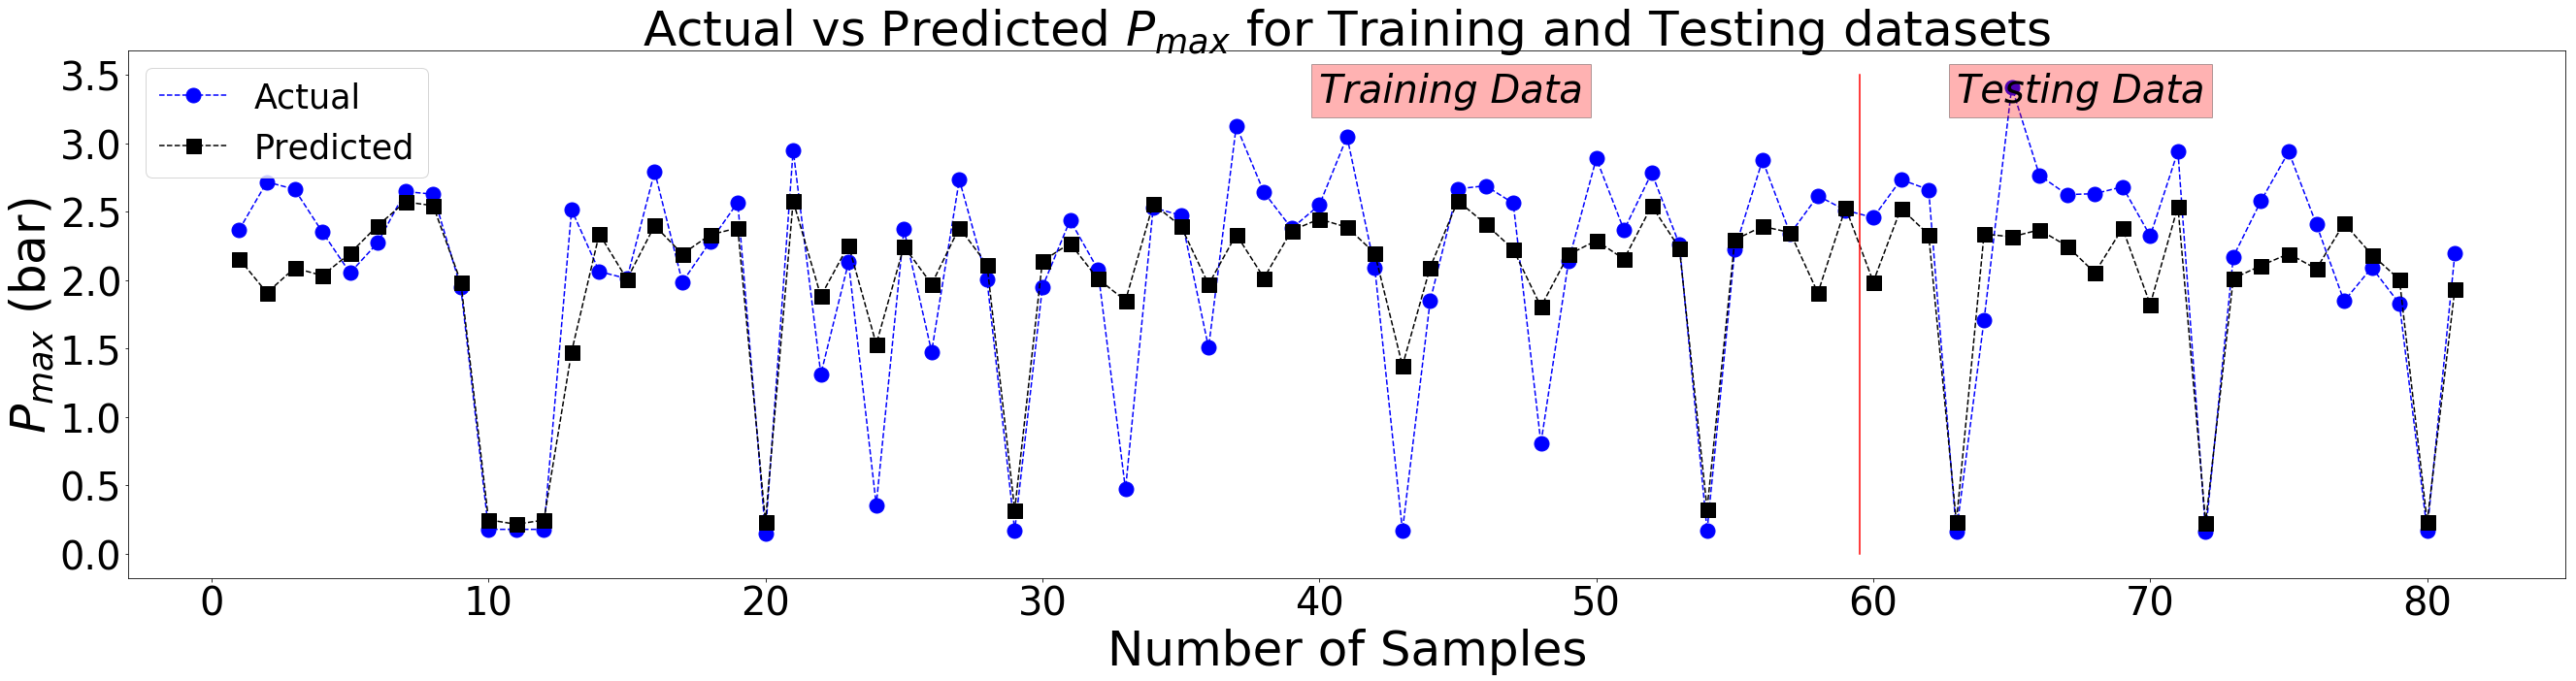

In [645]:
plt.figure(figsize=(45,10))
plt.plot(range(1,len(Data.iloc[:,0])+1),Yx,marker='o',markersize=15,linestyle='dashed',color='blue',label='Actual')
plt.plot(range(1,len(Data.iloc[:,0])+1),Px,marker='s',markersize=15,linestyle='dashed',color='black',label='Predicted')
plt.xlabel('Number of Samples',size=50)
plt.ylabel("$P_{max}$ (bar)",size=50)
plt.title('Actual vs Predicted $P_{max}$ for Training and Testing datasets',size=50)
plt.xticks(size=40)
plt.yticks(size=40)
x1, y1 = [59.5, 59.5], [0, 3.5]
plt.plot(x1,y1,color='red')
plt.legend(prop={"size":35})
plt.text(40, 3.3, 'Training Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=40)
plt.text(63, 3.3, 'Testing Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=40)
plt.savefig('C:/Users/Saad/Desktop/Models/{}/3Pmax'.format(m),dpi=100,bbox_inches='tight')
plt.show()

In [646]:
Yy = Y_act[:,1]
Py = Y_pred[:,1]

In [647]:
Two = pearsonr(Yy,Py)
print(Two[0])

0.9233148754241445


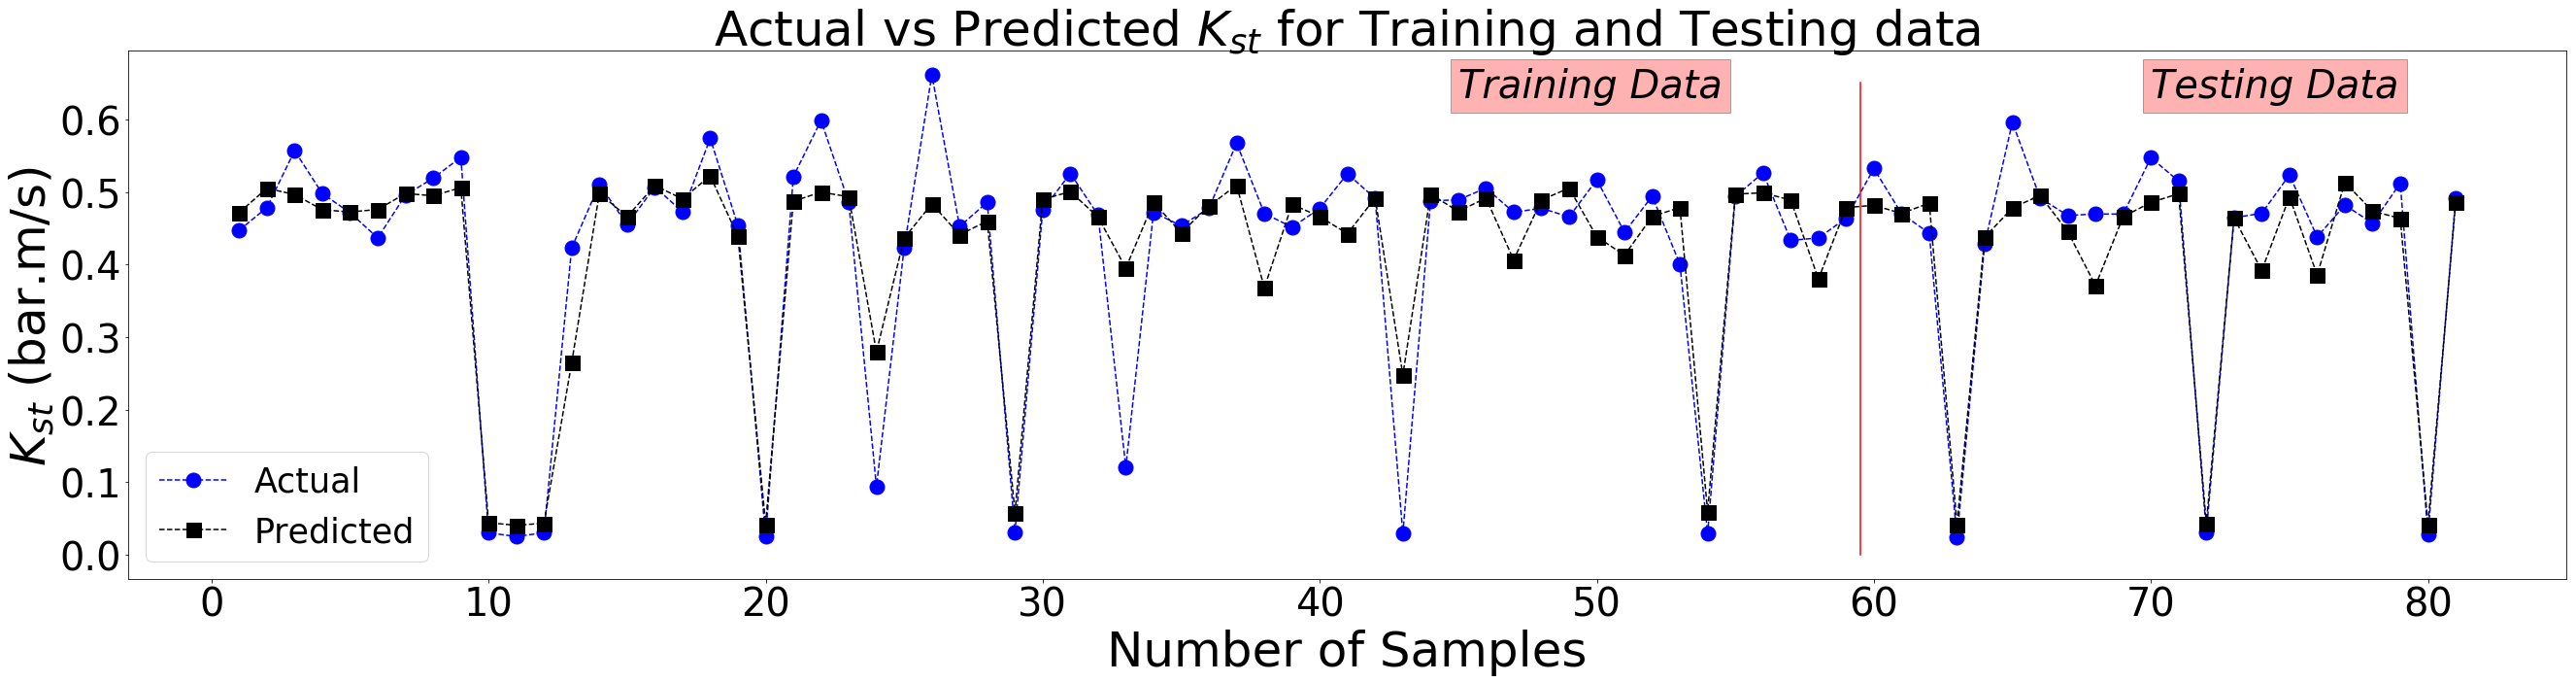

In [648]:
plt.figure(figsize=(45,10))
plt.plot(range(1,len(Data.iloc[:,0])+1),Yy,marker='o',markersize=15,linestyle='dashed',color='blue',label='Actual')
plt.plot(range(1,len(Data.iloc[:,0])+1),Py,marker='s',markersize=15,linestyle='dashed',color='black',label='Predicted')
plt.xlabel('Number of Samples',size=50)
plt.ylabel("$K_{st}$ (bar.m/s)",size=50)
plt.title('Actual vs Predicted $K_{st}$ for Training and Testing data',size=50)
plt.xticks(size=40)
plt.yticks(size=40)
x1, y1 = [59.5, 59.5], [0, 0.65]
plt.plot(x1,y1,color='red')
plt.legend(prop={"size":35},loc='top left')
plt.text(45, 0.63, 'Training Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=40)
plt.text(70, 0.63, 'Testing Data', style='italic', bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 8},fontsize=40)
plt.savefig('C:/Users/Saad/Desktop/Models/{}/4Kst'.format(m),dpi=100,bbox_inches='tight')
plt.show()

In [649]:
all_preds = mod.predict(X)


X_df = pd.DataFrame(X)

x_df = X_df.copy(deep=True)
x_df_1st = x_df.copy(deep=True)
x_df_2nd = x_df.copy(deep=True)

x_df_1st['1st'] = all_preds[:,0]
x_df_2nd['2nd'] = all_preds[:,1]

x_df = x_df.reset_index().drop('index',axis=1)
x_df_1st = x_df_1st.reset_index().drop('index',axis=1)
x_df_2nd = x_df_2nd.reset_index().drop('index',axis=1)


shap_values = shap.TreeExplainer(mod).shap_values(x_df)
#shap.summary_plot(shap_values, x_df)

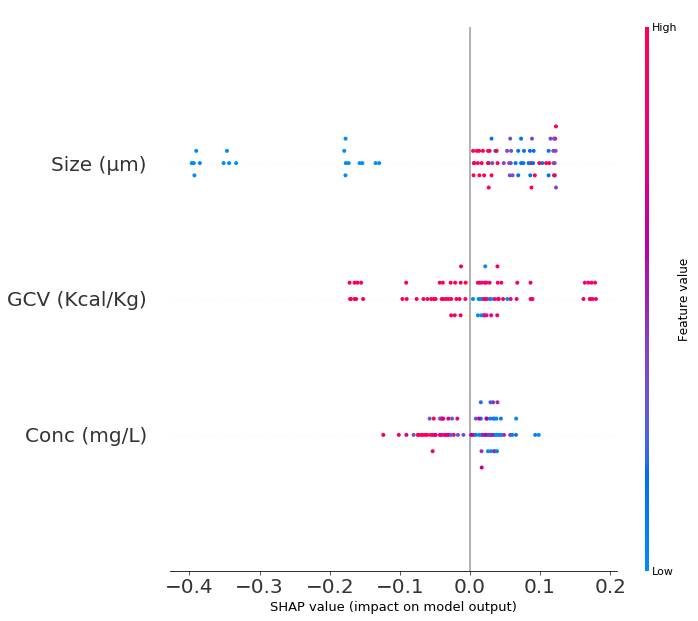

In [650]:
'Effect of input parameters on Pmax'
shap.summary_plot(shap_values[0], x_df,plot_size=(10,10),show=False,plot_type='dot')
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('C:/Users/Saad/Desktop/Models/{}/5Pmax_summary.jpg'.format(m),dpi=100,bbox_inches='tight')

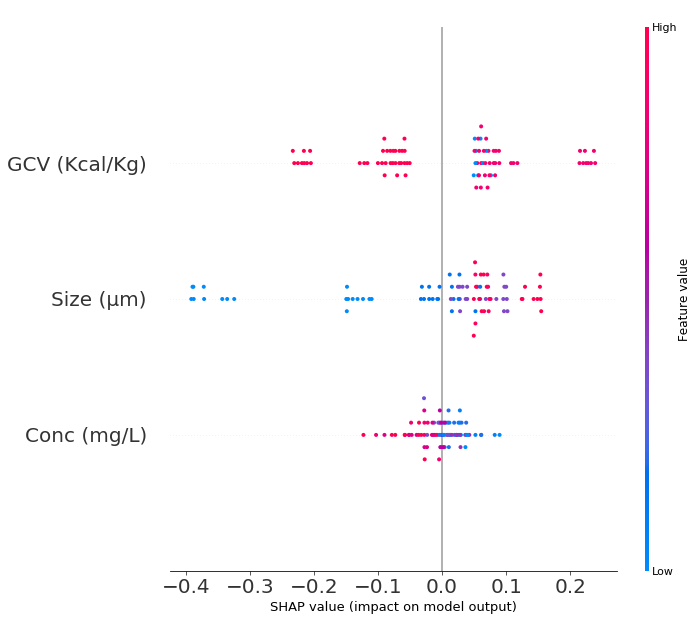

In [651]:
'Effect of inputs parameters on Kst'
shap.summary_plot(shap_values[1], x_df,plot_size=(10,10),show=False)
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('C:/Users/Saad/Desktop/Models/{}/6Kst_summary.jpg'.format(m),dpi=100,bbox_inches='tight')

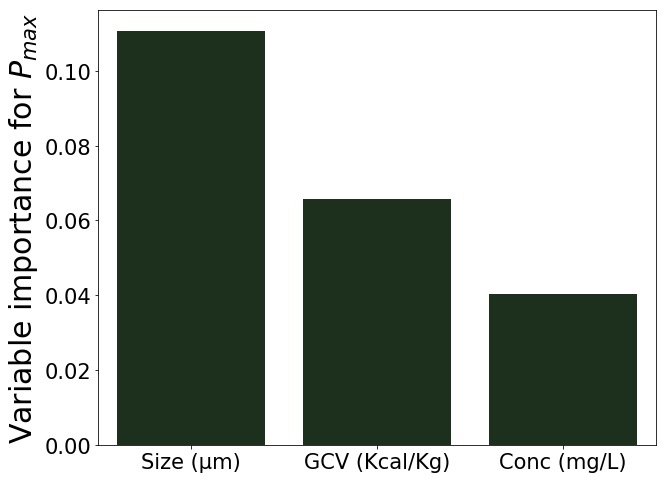

In [652]:
shap_values = shap.TreeExplainer(rf).shap_values(x_df)
feature_imp = np.mean(np.abs(shap_values[0]),axis=0)
feature_imp.shape

# top 20 important features
ind = feature_imp.argsort()[-20:]
ind = ind[::-1] #arranging in descending order

np.array(x_df.columns)[ind]
feature_imp[ind]

plt.figure(figsize=(10,8))
plot = sns.barplot(x=np.array(x_df.columns)[ind],y=feature_imp[ind],color=[0.1,0.2,0.1])
plot.set_xticklabels(plot.get_xticklabels(), horizontalalignment='center',size=12)
plt.yticks(size=21)
plt.xticks(size=21)
plt.ylabel('Variable importance for $P_{max}$',size=30)
plt.savefig('C:/Users/Saad/Desktop/Models/{}/7Feat_imp_Pmax.jpg'.format(m),dpi=100,bbox_inches='tight')

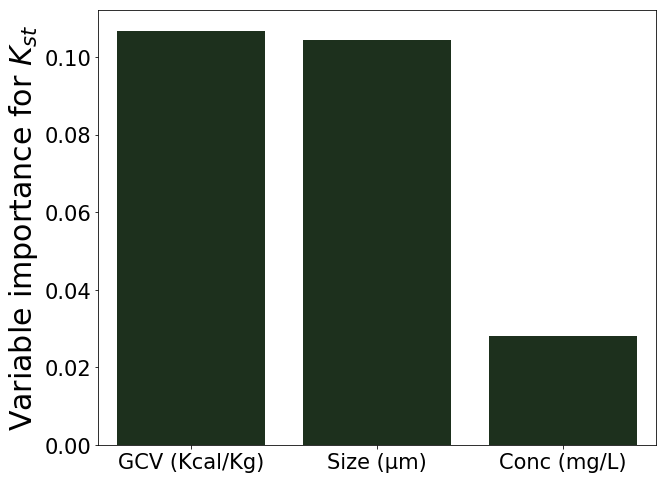

In [653]:
shap_values = shap.TreeExplainer(rf).shap_values(x_df)
feature_imp = np.mean(np.abs(shap_values[1]),axis=0)
feature_imp.shape

# top 20 important features
ind = feature_imp.argsort()[-20:]
ind = ind[::-1] #arranging in descending order

np.array(x_df.columns)[ind]
feature_imp[ind]

plt.figure(figsize=(10,8))
plot = sns.barplot(x=np.array(x_df.columns)[ind],y=feature_imp[ind],color=[0.1,0.2,0.1])
plot.set_xticklabels(plot.get_xticklabels(), horizontalalignment='center',size=12)
plt.yticks(size=21)
plt.xticks(size=21)
plt.ylabel('Variable importance for $K_{st}$',size=30)
plt.savefig('C:/Users/Saad/Desktop/Models/{}/8Feat_imp_Kst.jpg'.format(m),dpi=100,bbox_inches='tight')

In [654]:
Data_new = Data.drop(['Pmax(bar)','Kst(bar.m/s)'],axis=1)

In [655]:
Data_new.columns = ['Concentration','Particle Size','GCV']

In [656]:
Data_new.iloc[:,2].unique().mean()

5779.8

In [657]:
means = [405.55,62.0,5779.8]

   Concentration  Particle Size     GCV
0             50           62.0  5779.8
1            100           62.0  5779.8
2            200           62.0  5779.8
3            300           62.0  5779.8
4            400           62.0  5779.8
5            500           62.0  5779.8
6            600           62.0  5779.8
7            700           62.0  5779.8
8            800           62.0  5779.8
   Concentration  Particle Size     GCV
0         405.55             30  5779.8
1         405.55             40  5779.8
2         405.55             55  5779.8
3         405.55             90  5779.8
4         405.55             95  5779.8
   Concentration  Particle Size     GCV
0         405.55           62.0  4901.0
1         405.55           62.0  6120.2
2         405.55           62.0  6318.2


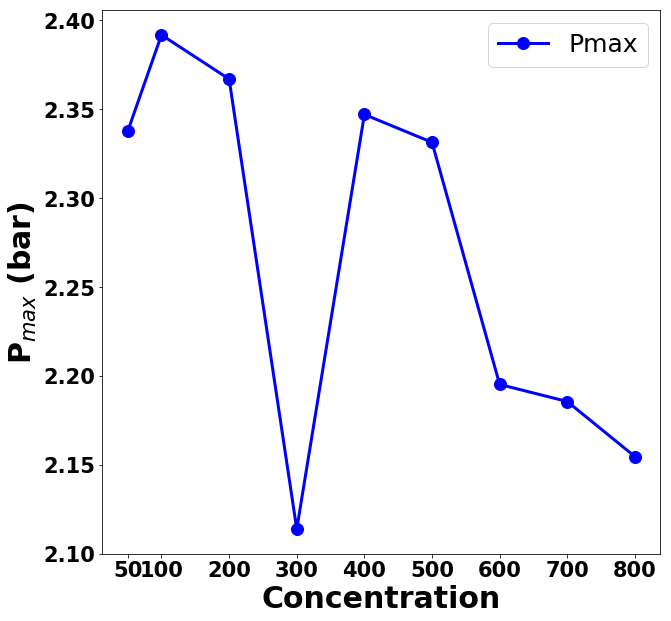

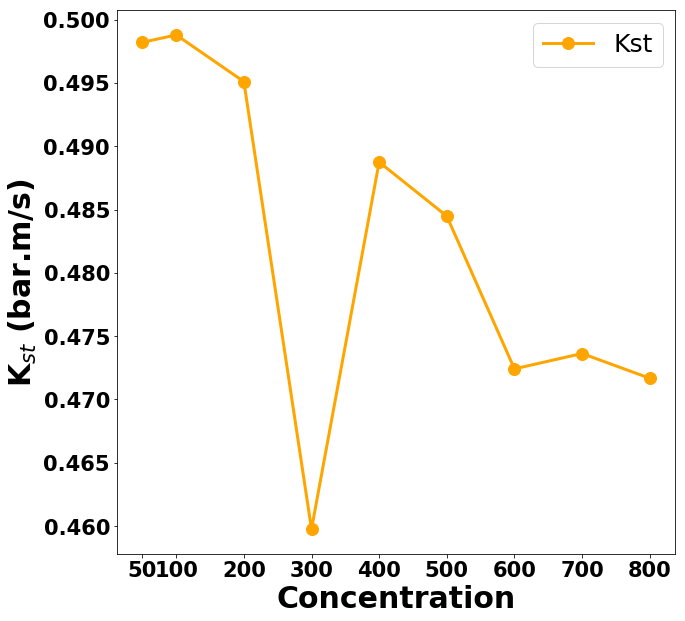

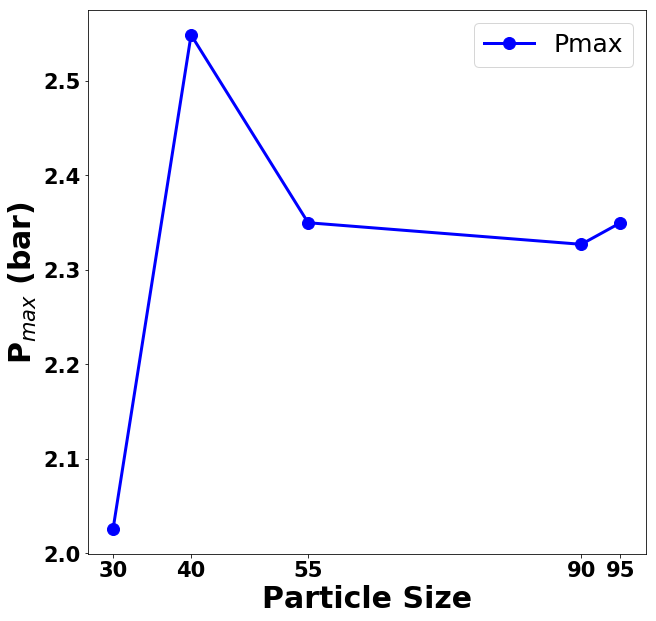

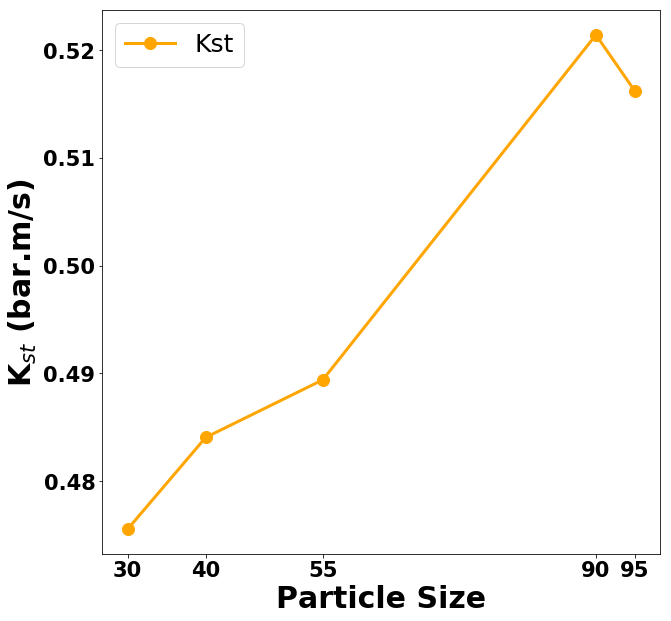

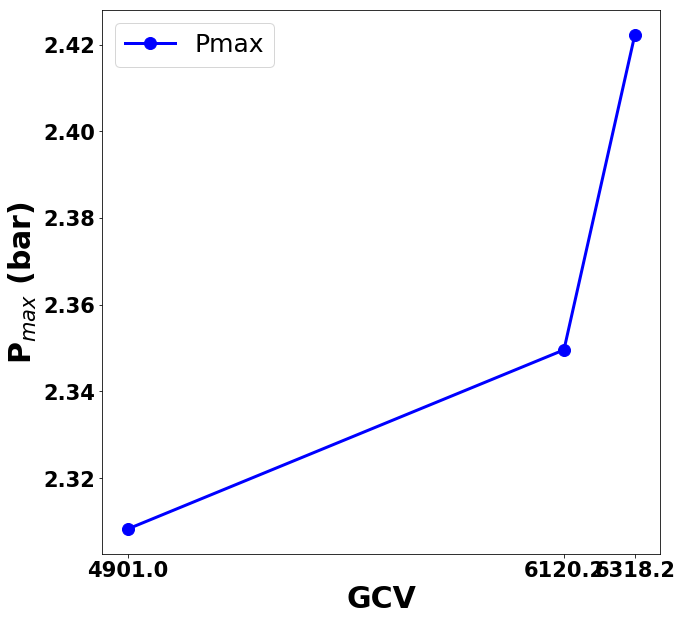

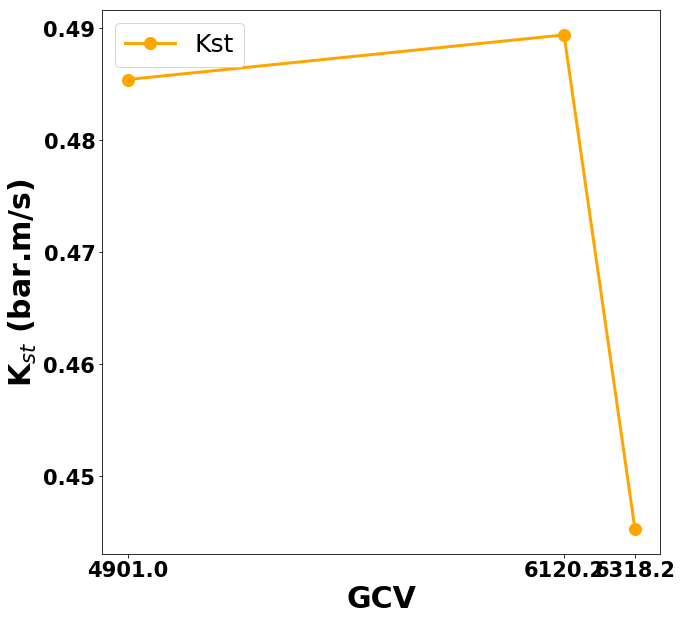

In [658]:
#means = list(Data_new.iloc[:,:].mean())
for i,p in zip(range(len(Data_new.columns)),Data_new.columns):
    conc = np.sort(list(set(Data_new.iloc[:,i])))
    x = {}
    for v,s in zip(Data_new.columns,range(len(Data_new.columns))):
        x.update({v:np.repeat(means[s],len(conc))})
    y = pd.DataFrame(x)
    if i == 0:
        y.iloc[:,0] = conc
    elif i == 1:
        y.iloc[:,1] = conc
    elif i == 2:
        y.iloc[:,2] = conc
    elif i == 3:
        y.iloc[:,3] = conc
    elif i == 4:
        y.iloc[:,4] = conc
    elif i == 5:
        y.iloc[:,5] = conc
    print(y)
    
    x = Scaler_X.transform(y)
    new_preds = rf.predict(x)
    new_preds = Scaler_Y.inverse_transform(new_preds)

    x_axis = [1,2,3,4,5,6]
    plt.figure(figsize=(10,10))
    plt.plot(conc,new_preds[:,0],label='Pmax',color='blue',linewidth=3,
             markersize=12,marker='o', markerfacecolor='blue')
    #plt.plot(Concentration.iloc[:,4],new_preds[:,1],marker='s',linestyle='--',label='Kst')
    plt.xlabel('{}'.format(p),size=30,weight='bold')
    plt.ylabel('P$_{max}$ (bar)',size=30,weight='bold')
    plt.legend(fontsize=25)
    my_xticks = conc
    plt.xticks(conc,my_xticks,size=21,weight='bold')
    plt.yticks(size=21,weight='bold')
    plt.savefig('C:/Users/Saad/Desktop/Models/{}/1Pmax {}.jpg'.format(m,p),dpi=100,bbox_inches='tight')

    x_axis = [1,2,3,4,5,6]
    plt.figure(figsize=(10,10))
    plt.plot(conc,new_preds[:,1],label='Kst',color='orange',linewidth=3,
             markersize=12,marker='o', markerfacecolor='orange')
    #plt.plot(Concentration.iloc[:,4],new_preds[:,1],marker='s',linestyle='--',label='Kst')
    plt.xlabel('{}'.format(p),size=30,weight='bold')
    plt.ylabel('K$_{st}$ (bar.m/s)',size=30,weight='bold')
    plt.legend(fontsize=25)
    my_xticks = conc
    plt.xticks(conc,my_xticks,size=21,weight='bold')
    plt.yticks(size=21,weight='bold')
    plt.savefig('C:/Users/Saad/Desktop/Models/{}/2Kst {}.jpg'.format(m,p),dpi=100,bbox_inches='tight')

In [659]:
from sklearn.inspection import PartialDependenceDisplay

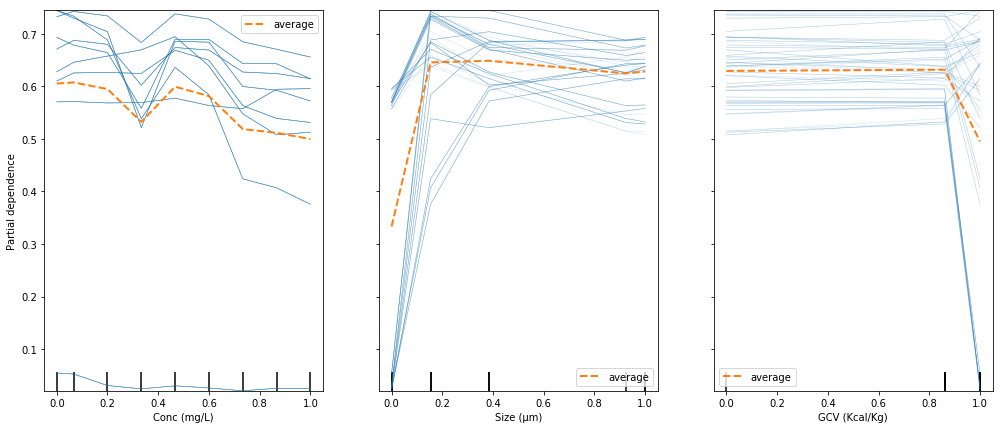

In [660]:
features = [0,1,2]
PartialDependenceDisplay.from_estimator(mod, X,features=features,kind='both',
                                        grid_resolution=1000,n_cols=3,target=0,
                                        ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                                        pd_line_kw={"color": "tab:orange", "linestyle": "--","linewidth": 2})
fig = plt.gcf()
fig.set_size_inches(17,7)
plt.savefig('C:/Users/Saad/Desktop/Models/{}/Partial Dependence1.jpg'.format(m),dpi=100,bbox_inches='tight')

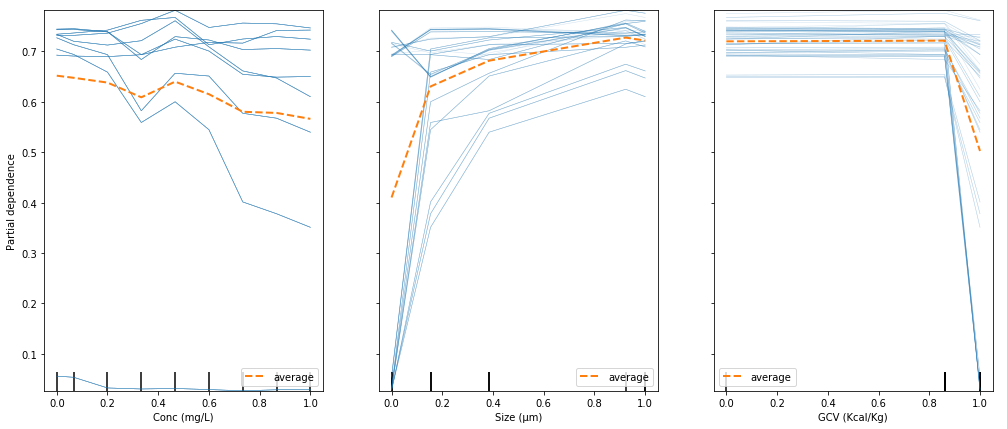

In [661]:
features = [0,1,2]
PartialDependenceDisplay.from_estimator(mod, X,features=features,kind='both',
                                        grid_resolution=1000,n_cols=3,target=1,
                                        ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                                        pd_line_kw={"color": "tab:orange", "linestyle": "--","linewidth": 2})
fig = plt.gcf()
fig.set_size_inches(17,7)
plt.savefig('C:/Users/Saad/Desktop/Models/{}/Partial Dependence2.jpg'.format(m),dpi=100,bbox_inches='tight')

In [662]:
fig.get_dpi()

72.0